# Predictive Maintenance using Machine Learning on Sagemaker
*Part 4 - Model evaluation*

## Initialization
---
Directory structure to run this notebook:
```
sagemaker-predictive-maintenance
|
+--- data
|   |
|   +--- interim: intermediate data we can manipulate and process
|   |
|   \--- raw: *immutable* data downloaded from the source website
|
+--- notebooks: all the notebooks are positionned here
```

### Imports

In [1]:
import os
import matplotlib.pyplot as plt
import time
import sagemaker
import boto3
import seaborn as sns
import pandas as pd

from sagemaker.predictor import RealTimePredictor, csv_serializer, csv_deserializer
from datetime import datetime
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, roc_auc_score, precision_score, recall_score, f1_score

# Helper functions
import utils

sns.set_style('darkgrid')

### Loading data from the previous notebook

In [2]:
%store -r

# If the data are not present in the notebook local storage, we need to load them from disk:
success_msg = 'Loaded "data", "columns", "xgb_classification_job", and "xgb_regression_job"'
if 'X_train' not in locals():
    try:
        local_path = '../data/interim'
        data = pd.read_csv(os.path.join(local_path, 'data.csv'))
        X_train = pd.read_csv(os.path.join(local_path, 'X_train.csv'))

        with open(os.path.join(local_path, 'columns.txt'), 'r') as f:
            columns = f.readline().split(',')
            
        with open(os.path.join(local_path, 'job_names.txt'), 'r') as f:
            xgb_classification_job = f.readline()
            xgb_regression_job = f.readline()
            
        print(success_msg)
            
    except Exception as e:
        if (e.errno == errno.ENOENT):
            print('Files not found to load data from: you need to execute the previous notebook.')
            
else:
    print(success_msg)

Loaded "data", "columns", "xgb_classification_job", and "xgb_regression_job"


### Set general information about this SageMaker session

In [3]:
role = sagemaker.get_execution_role()
session = sagemaker.Session()
bucket_name = session.default_bucket()
region = boto3.Session().region_name
prefix = 'nasa_engine_data'

## Models validation
---
### Preparing the testing data

In [4]:
test_dataset_path = '../data/interim/test_FD001.txt'
ground_truth_dataset_path = '../data/interim/RUL_FD001.txt'

In [5]:
rul_data = pd.read_csv(ground_truth_dataset_path, header=None, sep=' ')
rul_data.dropna(axis='columns', how='all', inplace=True)
rul_data.columns = ['rul']
print(rul_data.shape)
rul_data.head()

(100, 1)


,rul
0,112
1,98
2,69
3,82
4,91


In [6]:
test_data = pd.read_csv(test_dataset_path, header=None, sep=' ')
test_data.dropna(axis='columns', how='all', inplace=True)
test_data.columns = columns

tmp = pd.DataFrame(test_data.groupby(by='unit_number')['time'].max()).reset_index()
tmp.columns = ['unit_number', 'max']

rul_data['rul_failed'] = rul_data['rul'] + tmp['max']
rul_data['unit_number'] = rul_data.index + 1
rul_data = rul_data[['unit_number', 'rul', 'rul_failed']]
rul_data.head()

,unit_number,rul,rul_failed
0,1,112,143
1,2,98,147
2,3,69,195
3,4,82,188
4,5,91,189


In [7]:
test_data = test_data.merge(rul_data.drop(['rul'], axis=1), on=['unit_number'], how='left')
test_data['rul'] = test_data['rul_failed'] - test_data['time']
test_data.drop(columns=['rul_failed'], axis='columns', inplace=True)
tmp = test_data[X_train.columns]

low_cycle = 30
test_data['label'] = test_data['rul'].apply(lambda x: 1 if x <= low_cycle else 0)
test_data.head()

,unit_number,time,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,rul,label
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0


In [8]:
# Get the scaler previously persisted on S3 to transform the test data 
# using the same normalization method than for the training dataset:
session.download_data('.', bucket=bucket_name, key_prefix='{}/preprocessing/MinMaxScaler.joblib'.format(prefix))
scaler = joblib.load('./MinMaxScaler.joblib')

# Normalize the test data:
test_data_scaled = pd.DataFrame(scaler.transform(tmp))
test_data_scaled.columns = X_train.columns
test_data_scaled = pd.concat([test_data[['unit_number', 'time', 'rul', 'label']], test_data_scaled], axis='columns')
test_data_scaled.head()

,unit_number,time,rul,label,operational_setting_1,operational_setting_2,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_6,...,sensor_measurement_8,sensor_measurement_9,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_17,sensor_measurement_20,sensor_measurement_21
0,1,1,142,0,0.698718,0.750000,0.542587,0.280233,0.227457,1.0,...,0.295455,0.140465,0.203593,0.635165,0.291667,0.135225,0.284262,0.3,0.615385,0.701860
1,1,2,141,0,0.378205,0.250000,0.129338,0.356969,0.173586,1.0,...,0.227273,0.163648,0.383234,0.731868,0.354167,0.218930,0.174182,0.4,0.752137,0.728364
2,1,3,140,0,0.570513,0.583333,0.365931,0.320301,0.287893,1.0,...,0.318182,0.177504,0.383234,0.690110,0.291667,0.162294,0.456233,0.4,0.803419,0.764973
3,1,4,139,0,0.820513,0.500000,0.359621,0.251821,0.385982,1.0,...,0.272727,0.113845,0.251497,0.560440,0.333333,0.178952,0.224580,0.2,0.735043,0.702153
4,1,5,138,0,0.641026,0.500000,0.381703,0.326372,0.299092,1.0,...,0.227273,0.109808,0.269461,0.729670,0.291667,0.158962,0.274978,0.1,0.726496,0.759701


### Deploying an endpoint for the trained models
The Estimator objects for both the classification and the regression models were created in the previous Notebook and we don't have them readily available to use right here. We will have to build an endpoint from scratch: this is a good way to have a notebook as independant as possible from the training process itself though. The `xgb_classification_job` and `xgb_regression_job` variables were persisted at the end of the previous notebook. Note that the `.deploy` method from the Estimator objects goes through all these steps for you under the hood

#### Endpoint for the classification model

In [9]:
classification_endpoint_name = 'xgboost-nasa-classification-v1-{}'.format(datetime.now().strftime("%Y%m%d-%H%M%S"))
print('The following endpoint will be created:', classification_endpoint_name)

# Get the training job descriptor to extract the location of the 
# model artifacts on S3 and the container for the algorithm image:
sm_client = boto3.client('sagemaker')
training_job_description = sm_client.describe_training_job(TrainingJobName=xgb_classification_job)
model_artifacts = training_job_description['ModelArtifacts']['S3ModelArtifacts']
training_image = training_job_description['AlgorithmSpecification']['TrainingImage']

# Create a deployable model:
sm_client.create_model(
    ModelName = classification_endpoint_name + '-model',
    ExecutionRoleArn = role,
    PrimaryContainer = {
        'Image': training_image,
        'ModelDataUrl': model_artifacts
    }
)

# Creates the endpoint configuration: this entity describes the distribution of traffic 
# across the models, whether split, shadowed, or sampled in some way:
sm_client.create_endpoint_config(
    EndpointConfigName = classification_endpoint_name + '-endpoint-cfg',
    ProductionVariants=[{
        'InstanceType': 'ml.t2.medium',
        'InitialVariantWeight': 1,
        'InitialInstanceCount': 1,
        'ModelName': classification_endpoint_name + '-model',
        'VariantName':'AllTraffic'
    }]
)

# Creates the endpoint: this entity serves up the model, through 
# specifying the name and configuration defined above:
xgb_classification_predictor = sm_client.create_endpoint(
    EndpointName = classification_endpoint_name,
    EndpointConfigName = classification_endpoint_name + '-endpoint-cfg'
)

The following endpoint will be created: xgboost-nasa-classification-v1-20200515-065003


In [10]:
status = sm_client.describe_endpoint(EndpointName=classification_endpoint_name)['EndpointStatus']
print('Endpoint creation in progress... ', end='')
while status == 'Creating':
    time.sleep(60)
    print('#', end='')
    status = sm_client.describe_endpoint(EndpointName=classification_endpoint_name)['EndpointStatus']
    
if (status == 'InService'):
    print('\nEndpoint creation successful.')
    
    # Build a predictor object which will receive our prediction requests:
    xgb_classification_predictor = RealTimePredictor(
        endpoint = classification_endpoint_name,
        sagemaker_session = session,
        serializer = csv_serializer,
        deserializer = csv_deserializer
    )
    
else:
    print('\nEndpoint creation failed.')

Endpoint creation in progress...
Endpoint creation in progress...
Endpoint creation in progress...
Endpoint creation in progress...
Endpoint creation in progress...
Endpoint creation in progress...
Endpoint creation in progress...
Endpoint creation in progress...
Endpoint creation in progress...
Endpoint creation successful.


#### Endpoint for the regression model

In [28]:
regression_endpoint_name = 'xgboost-nasa-regression-v1-{}'.format(datetime.now().strftime("%Y%m%d-%H%M%S"))
print('The following endpoint will be created:', regression_endpoint_name)

# Get the training job descriptor to extract the location of the 
# model artifacts on S3 and the container for the algorithm image:
sm_client = boto3.client('sagemaker')
training_job_description = sm_client.describe_training_job(TrainingJobName=xgb_regression_job)
model_artifacts = training_job_description['ModelArtifacts']['S3ModelArtifacts']
training_image = training_job_description['AlgorithmSpecification']['TrainingImage']

# Create a deployable model:
sm_client.create_model(
    ModelName = regression_endpoint_name + '-model',
    ExecutionRoleArn = role,
    PrimaryContainer = {
        'Image': training_image,
        'ModelDataUrl': model_artifacts
    }
)

# Creates the endpoint configuration: this entity describes the distribution of traffic 
# across the models, whether split, shadowed, or sampled in some way:
sm_client.create_endpoint_config(
    EndpointConfigName = regression_endpoint_name + '-endpoint-cfg',
    ProductionVariants=[{
        'InstanceType': 'ml.t2.medium',
        'InitialVariantWeight': 1,
        'InitialInstanceCount': 1,
        'ModelName': regression_endpoint_name + '-model',
        'VariantName':'AllTraffic'
    }]
)

# Creates the endpoint: this entity serves up the model, through 
# specifying the name and configuration defined above:
xgb_regression_predictor = sm_client.create_endpoint(
    EndpointName = regression_endpoint_name,
    EndpointConfigName = regression_endpoint_name + '-endpoint-cfg'
)

The following endpoint will be created: xgboost-nasa-regression-v1-20200515-071140


In [29]:
status = sm_client.describe_endpoint(EndpointName=regression_endpoint_name)['EndpointStatus']
print('Endpoint creation in progress... ', end='')
while status == 'Creating':
    time.sleep(60)
    print('#', end='')
    status = sm_client.describe_endpoint(EndpointName=regression_endpoint_name)['EndpointStatus']
    
if (status == 'InService'):
    print('\nEndpoint creation successful.')
    
    # Build a predictor object which will receive our prediction requests:
    xgb_regression_predictor = RealTimePredictor(
        endpoint = regression_endpoint_name,
        sagemaker_session = session,
        serializer = csv_serializer,
        deserializer = csv_deserializer
    )
    
else:
    print('\nEndpoint creation failed.')

Endpoint creation in progress... #######
Endpoint creation successful.


### Measuring the performance of the classification model
#### Get the label predictions for the test data

In [13]:
# We want to evaluate the probability for each unit to be healty or not:
cls_results_df = pd.DataFrame(columns=['unit_number', 'real_label', 'predicted_label'])

# Loops through each unit:
for i in range(0, 100):
    # Get all the scaled test data for the current unit:
    row = test_data_scaled[test_data_scaled['unit_number'] == (i+1)].iloc[-1, :]
    
    # Join them together into a list before sending them to the predictor:
    test_sample = ', '.join(row[X_train.columns].map(str).tolist())
    prediction = xgb_classification_predictor.predict(test_sample)
    
    # Add the result for the current unit to the results dataframe:
    cls_results_df = cls_results_df.append({
        'unit_number': (i+1),
        'real_label': row['label'],
        'predicted_label': round(float(prediction[0][0]))
    }, ignore_index=True)
    
cls_results_df = cls_results_df.set_index('unit_number')
cls_results_df.head()

,real_label,predicted_label
unit_number,,
1.0,0.0,0.0
2.0,0.0,0.0
3.0,0.0,0.0
4.0,0.0,0.0
5.0,0.0,0.0


#### Classification scores

In [14]:
y = cls_results_df['real_label']
yhat = cls_results_df['predicted_label']

print('Classification scores:')
print('- Accuracy:', round(accuracy_score(y, yhat), 2))
print('- Roc AuC:', round(roc_auc_score(y, yhat), 2))
print('- Precision:', round(precision_score(y, yhat), 2))
print('- Recall:', round(recall_score(y, yhat), 2))
print('- F1 score:', round(f1_score(y, yhat,'binary'), 2))

Classification scores:
- Accuracy: 0.94
- Roc AuC: 0.89
- Precision: 0.95
- Recall: 0.8
- F1 score: 0.87


#### Confusion matrix

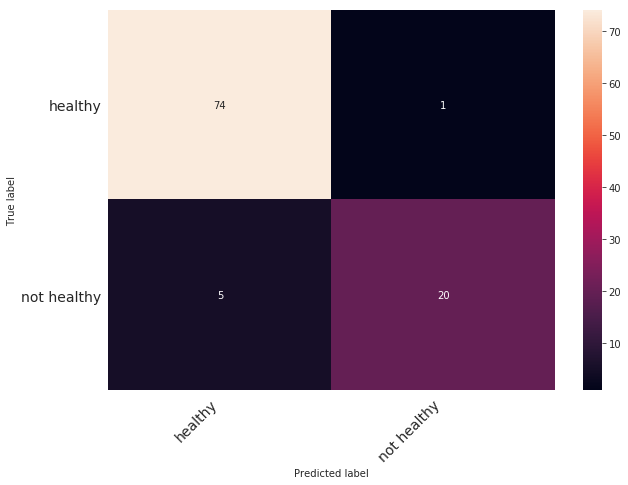

In [15]:
cm = confusion_matrix(y, yhat)
fig = utils.print_confusion_matrix(cm, ['healthy', 'not healthy'])

### Measuring the performance of the regression model
#### Get the RUL predictions for the test data

In [16]:
# We want to estimate the remaining useful lifetime for each unit:
reg_results_df = pd.DataFrame(columns=['unit_number', 'real_rul', 'predicted_rul'])

# Loops through each unit:
for i in range(0, 100):
    # Get all the test data for the current unit:
    row = test_data_scaled[test_data_scaled['unit_number'] == (i+1)].iloc[-1, :]
    
    # Join them together into a list before sending them to the predictor:
    test_sample = ', '.join(row[X_train.columns].map(str).tolist())
    prediction = xgb_regression_predictor.predict(test_sample)
    
    # Add the result for the current unit to the results dataframe:
    reg_results_df = reg_results_df.append({
        'unit_number': (i+1),
        'real_rul': row['rul'],
        'predicted_rul': float(prediction[0][0])
    }, ignore_index=True)
    
reg_results_df = reg_results_df.set_index('unit_number')
reg_results_df.head()

,real_rul,predicted_rul
unit_number,,
1.0,112.0,206.669495
2.0,98.0,121.977745
3.0,69.0,31.511415
4.0,82.0,77.445061
5.0,91.0,104.225723


#### Scoring the regression model

In [17]:
from sklearn.metrics import r2_score

print('R²:', r2_score(reg_results_df['real_rul'], reg_results_df['predicted_rul']))

R²: 0.4395086423376081


#### Scatter plot for predicted RUL vs. real RUL

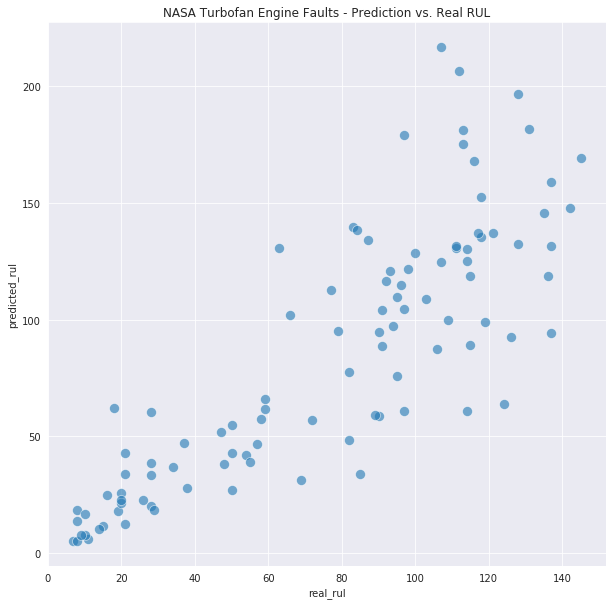

In [18]:
figure=plt.figure(figsize=(10,10))
chart = sns.scatterplot(x=reg_results_df['real_rul'], y=reg_results_df['predicted_rul'], s=100, alpha=0.6);
chart.set_title('NASA Turbofan Engine Faults - Prediction vs. Real RUL');

## Conclusion
---
Although the training graphs for the classification model hinted overfitting, we get a **decent classification performance**. On the other hand, the **regression model still needs vast improvement** (with a very low R² at this stage) so that it can be used in a predictive maintenance context. However, we can already see on the previous figure that we are capturing the right prediction behaviour.
### Cleanup

In [31]:
sm_client.delete_endpoint(EndpointName=classification_endpoint_name);
sm_client.delete_endpoint_config(EndpointConfigName=classification_endpoint_name + '-endpoint-cfg');
sm_client.delete_model(ModelName=classification_endpoint_name + '-model');
sm_client.delete_endpoint(EndpointName=regression_endpoint_name);
sm_client.delete_endpoint_config(EndpointConfigName=regression_endpoint_name + '-endpoint-cfg');
sm_client.delete_model(ModelName=regression_endpoint_name + '-model');

### Storing data for the next notebook

In [20]:
%store test_data_scaled
%store reg_results_df
%store cls_results_df

Stored 'test_data_scaled' (DataFrame)
Stored 'reg_results_df' (DataFrame)
Stored 'cls_results_df' (DataFrame)


### Persisting these data to disk
This is useful in case you want to be able to execute each notebook independantly (from one session to another) and don't want to reexecute every notebooks whenever you want to focus on a particular step.

In [22]:
# Create the local path for our artifacts:
local_path = '../data/interim'
os.makedirs(local_path, exist_ok=True)

# Write the dataframes:
test_data_scaled.to_csv('test_data_scaled.csv')
reg_results_df.to_csv('reg_results_df')
cls_results_df.to_csv('cls_results_df')